In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import scipy.linalg
import scipy.spatial.distance

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
DO_WHITENING = True
DO_CORAL = True
REG_PARAM = 1.0

# READ METADATA OF IMAGES (LEVEL 1)

In [3]:
featdir = "features_valid.npy"
meta = pd.read_csv("metadata.csv")

features = np.load(featdir)
print(features.shape)

(9982, 512)


# LOAD SINGLE CELL FEATURES (LEVEL 2)

In [4]:
num_features = features.shape[1]

# AGGREGATE INTO SITE LEVEL DATA (LEVEL 3)

In [5]:
site_level_data = []
site_level_features = []
for plate in tqdm(meta["Metadata_Plate"].unique()):
    m1 = meta["Metadata_Plate"] == plate
    wells = meta[m1]["Metadata_Well"].unique()
    for well in wells:
        result = meta.query("Metadata_Plate == '{}' and Metadata_Well == '{}'".format(plate, well))
        mean_profile = np.zeros(num_features, dtype=np.float64)
        for i in result.index:
            mean_profile += features[i]
        mean_profile /= len(result)
        compound = result["compound"].unique()
        concentration = result["concentration"].unique()
        replicate = result["Replicate"].unique()
        moa = result["moa"].unique()
        if len(compound) > 1 or len(concentration) > 1 or len(moa) > 1:
            print(compound, concentration, moa)
        site_level_data.append(
            {
                "Plate": plate,
                "Well": well,
                "Compound": compound[0],
                "Concentration": concentration[0],
                "Replicate": replicate[0],
                "MOA": moa[0]
            }
        )
        site_level_features.append(mean_profile)

100%|██████████| 17/17 [00:00<00:00, 40.22it/s]


In [6]:
columns1 = ["Plate", "Well", "Compound", "Concentration", "MOA", "Batch", "Replicate"]
columns2 = [i for i in range(num_features)]
sites1 = pd.DataFrame(columns=columns1, data=site_level_data)
sites1["Batch"] = sites1["Plate"].apply(lambda x: x.split("_")[0])
sites2 = pd.DataFrame(columns=columns2, data=site_level_features)
sites = pd.concat([sites1, sites2], axis=1)

# TYPICAL VARIATION NORMALIZATION

In [7]:
def whitening_transform(X, lambda_, rotate=True):
    C = (1/X.shape[0]) * np.dot(X.T, X)
    s, V = scipy.linalg.eigh(C)
    D = np.diag( 1. / np.sqrt(s + lambda_) )
    W = np.dot(V, D)
    if rotate:
        W = np.dot(W, V.T)
    return W

def whiten(X, mu, W):
    return np.dot( X - mu, W)

In [8]:
feature_ids = [i for i in range(num_features)]
    
if DO_WHITENING:
    # Compute center of data around controls
    controls = sites["Compound"] == "DMSO"
    mean_ctl = sites.loc[controls, feature_ids].mean()

    # Whitening transform on controls
    all_controls_matrix = sites.loc[controls, feature_ids] - mean_ctl
    W = whitening_transform(all_controls_matrix, REG_PARAM, rotate=False)
    sites[feature_ids] = whiten(sites[feature_ids], mean_ctl, W)


Is the covariance close the the identity? False
512.9573642756324


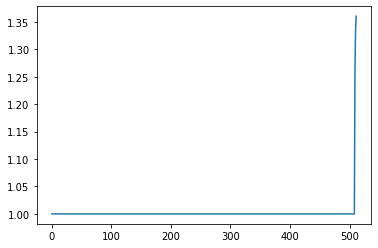

In [9]:
if DO_CORAL:
    # Compute target matrix
    CF = sites.loc[sites["Compound"] == "DMSO", feature_ids]
    C_target = (1/CF.shape[0]) * np.dot(CF.T, CF)
    print("Is the covariance close the the identity?", np.allclose(C_target, np.eye(C_target.shape[0])))

    I = REG_PARAM * np.eye(C_target.shape[0])
    C_target = np.real(scipy.linalg.sqrtm(C_target + I))
    
    print(np.sum(C_target))
    plt.plot(np.diag(C_target))
    #plt.imshow(C_target)

In [10]:
if DO_CORAL:
    aligned_feature_matrix = np.zeros_like(sites[feature_ids])
    plates = sites["Batch"].unique()
    for p in tqdm(plates):
        plate_data = sites[sites["Batch"] == p]
        plate_index = plate_data.index.tolist()
        is_control = plate_data.Compound == "DMSO"
        controls_index = plate_data[is_control].index

        controls_features = sites.iloc[controls_index][feature_ids]
        plate_features = sites.iloc[plate_index][feature_ids]
        
        C_source = (1/controls_features.shape[0]) * np.dot(controls_features.T, controls_features)
        print("Is the covariance close the the identity?", np.allclose(C_source, np.eye(C_source.shape[0])))
        C_source = scipy.linalg.inv( np.real( scipy.linalg.sqrtm(C_source + np.eye(C_source.shape[0])) ) )
        
        print(controls_features.shape, np.sum(C_source))
        plt.figure()
        plt.plot(np.diag(C_source))
        
        X = np.dot(np.dot(plate_features, C_source), C_target)
        aligned_feature_matrix[plate_index, :] = X
        
    sites[feature_ids] = aligned_feature_matrix

  0%|          | 0/10 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

# AGGREGATE INTO WELL DATA (LEVEL 4)

In [11]:
# Prepare MOA class IDs
moas = sites["MOA"].unique()
moa_to_id = {moas[i]:i for i in range(len(moas))}
id_to_moas = {moa_to_id[i]:i for i in moa_to_id.keys()}

# Collapse well data
wells = sites.groupby(["Plate", "Well", "Compound", "Concentration", "MOA"]).mean().reset_index()
wells = wells[wells["Compound"] != "DMSO"]
wells = wells[wells["Compound"] != "taxol"]
wells["MOA_class"] = wells["MOA"].apply(lambda x: moa_to_id[x])

# AGGREGATE INTO TREATMENTS (LEVEL 5)

In [12]:
treatments = sites.groupby(["Compound", "Concentration", "MOA"]).median().reset_index()
treatments = treatments.drop("Replicate", axis=1)
treatments = treatments[treatments["Compound"] != "DMSO"]
treatments["MOA_class"] = treatments["MOA"].apply(lambda x: moa_to_id[x])

In [13]:
treatments["Batch"] = ""
for i in treatments.index:
    result = sites.query("Compound == '{}' and Concentration == {}".format(treatments.loc[i,"Compound"], treatments.loc[i,"Concentration"]))
    treatments.loc[i,"Batch"] = ",".join(result["Batch"].unique())

# MOA CLASSIFICATION

## TREATMENT LEVEL - NOT SAME COMPOUND MATCHING

In [14]:
def knn(X, Y, T):
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm="brute", metric="cosine")
    neigh.fit(X, Y)
    prediction = neigh.predict(T)
    return prediction[0]

def nsc(treatments):
    treatments["nsc"] = 0
    correct, total = 0, 0
    for i in treatments.index:
        # Leave one compound out
        training_data = treatments[treatments["Compound"] != treatments.loc[i, "Compound"]]
        test_data = np.asarray(treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
            treatments.loc[i, "nsc"] = 1
        else:
            print(len(training_data), treatments.loc[i, "Compound"], treatments.loc[i, "Concentration"], treatments.loc[i, "MOA"], moas[prediction])
        total += 1
    print("NSC Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nsc(treatments)
#print(" >> WELL LEVEL")
#nsc(wells)

 >> TREATMENT LEVEL
101 ALLN 100.0 Protein degradation Microtubule stabilizers
97 AZ-A 0.1 Aurora kinase inhibitors DNA replication
97 AZ-A 10.0 Aurora kinase inhibitors DNA replication
96 AZ-C 0.001 Eg5 inhibitors Microtubule destabilizers
96 AZ-C 0.003 Eg5 inhibitors Microtubule destabilizers
96 AZ-C 0.01 Eg5 inhibitors Microtubule destabilizers
96 AZ-C 0.1 Eg5 inhibitors Microtubule destabilizers
96 AZ-C 0.3 Eg5 inhibitors Microtubule destabilizers
96 AZ-C 1.0 Eg5 inhibitors Microtubule destabilizers
98 AZ138 0.03 Eg5 inhibitors Microtubule destabilizers
98 AZ138 0.1 Eg5 inhibitors Microtubule destabilizers
101 PP-2 3.0 Epithelial Protein synthesis
101 PP-2 10.0 Epithelial Protein synthesis
101 anisomycin 0.3 Protein synthesis Protein degradation
101 anisomycin 1.0 Protein synthesis Actin disruptors
102 colchicine 0.03 Microtubule destabilizers DNA damage
100 cyclohexamide 5.0 Protein synthesis Epithelial
102 cytochalasin D 0.3 Actin disruptors Protein degradation
100 emetine 0.1 Pr

## TREATMENT LEVEL - NOT SAME COMPOUND, NOT SAME BATCH

In [15]:
def nscb(treatments):
    treatments["nscb"] = 1
    # Cholesterol-lowering and Kinase inhibitors are only in one batch
    valid_treatments = treatments[~treatments["MOA"].isin(["Cholesterol-lowering","Kinase inhibitors"])]
    
    correct, total = 0, 0
    for i in valid_treatments.index:
        # Leave same compound and batch out
        mask1 = valid_treatments["Compound"] != valid_treatments.loc[i, "Compound"]
        mask2 = valid_treatments["Batch"] != valid_treatments.loc[i, "Batch"]
        training_data = valid_treatments[mask1 & mask2]
        test_data = np.asarray(valid_treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if valid_treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
        else:
            print(len(training_data), 
                  valid_treatments.loc[i, "Compound"], 
                  valid_treatments.loc[i, "Concentration"], 
                  valid_treatments.loc[i, "MOA"], 
                  moas[prediction])
            treatments.loc[i, "nscb"] = 0
        total += 1
    print("NSCB Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nscb(treatments)

 >> TREATMENT LEVEL
86 ALLN 100.0 Protein degradation Microtubule stabilizers
73 AZ-A 0.1 Aurora kinase inhibitors DNA replication
73 AZ-A 10.0 Aurora kinase inhibitors DNA replication
84 AZ138 0.03 Eg5 inhibitors Microtubule destabilizers
84 AZ138 0.1 Eg5 inhibitors Microtubule destabilizers
86 MG-132 3.0 Protein degradation Protein synthesis
87 PP-2 3.0 Epithelial Protein synthesis
87 PP-2 10.0 Epithelial Protein synthesis
80 anisomycin 0.3 Protein synthesis Protein degradation
80 anisomycin 1.0 Protein synthesis Actin disruptors
73 colchicine 0.03 Microtubule destabilizers DNA damage
80 cyclohexamide 5.0 Protein synthesis Epithelial
73 cytochalasin B 10.0 Actin disruptors Protein synthesis
73 cytochalasin B 30.0 Actin disruptors Protein synthesis
86 cytochalasin D 0.3 Actin disruptors Microtubule stabilizers
63 demecolcine 0.3 Microtubule destabilizers Eg5 inhibitors
63 demecolcine 1.0 Microtubule destabilizers Eg5 inhibitors
63 demecolcine 3.0 Microtubule destabilizers Eg5 inhibito

# VISUALIZATION OF PROFILES

In [16]:
treated_wells = wells[~wells["Compound"].isin(["DMSO"])]#, "taxol"])]
treated_wells["nsc"] = -1
treated_wells["level"] = "wells"
treatments["level"] = "treatments"
embeddings = np.concatenate( [treated_wells[feature_ids], treatments[feature_ids]] )
C = scipy.spatial.distance.cdist(embeddings, embeddings, 'cosine')
tsne = TSNE()
projection = tsne.fit_transform(C)

In [17]:
df = pd.DataFrame(dict(
    x=projection[:,0],
    y=projection[:,1],
    moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    level=pd.concat([treated_wells["level"],treatments["level"]])
))

In [18]:
df = df[df.level == "treatments"]

/home/riddle/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

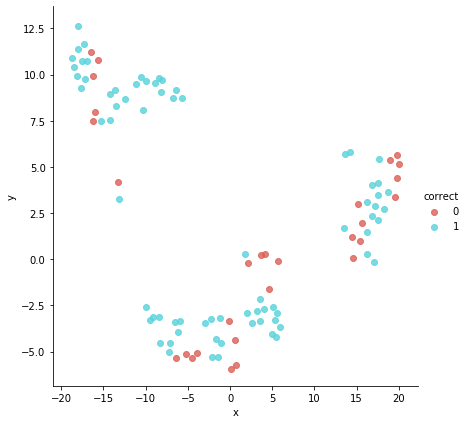

<Figure size 432x288 with 0 Axes>

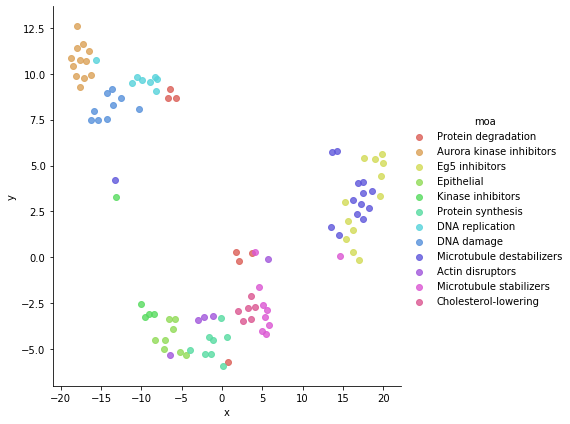

<Figure size 432x288 with 0 Axes>

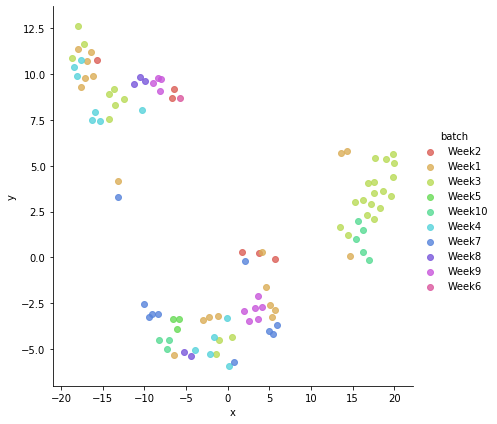

<Figure size 432x288 with 0 Axes>

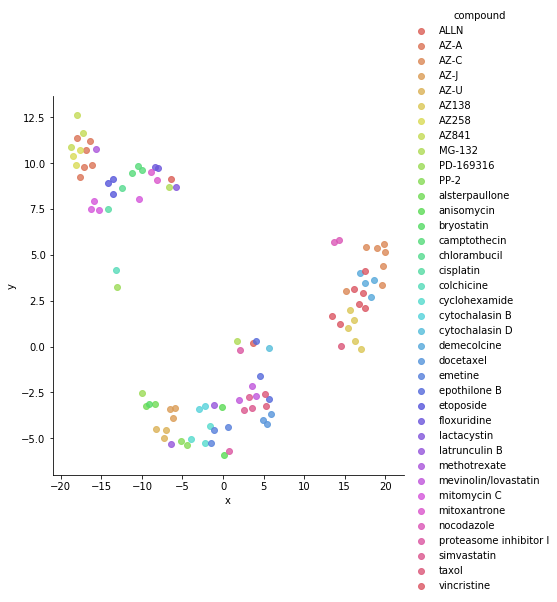

In [19]:
plt.figure()
sb.lmplot('x', 'y', data=df, hue='correct', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='moa', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='batch', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='compound', fit_reg=False, palette="hls", size=6)